## **주식 예측에 도전해 보자!**

### **STEP 1 : 시계열 데이터 준비 (Samsung)**
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
* 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
# DataFrame으로 변환
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [3]:
# Time Series 생성
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

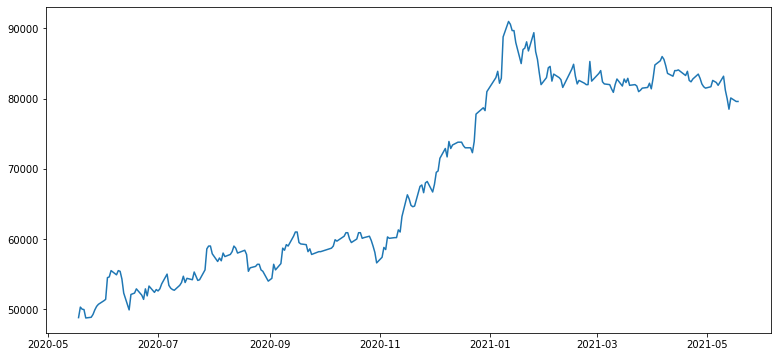

In [4]:
# 데이터 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

### **STEP 2 : 각종 전처리 수행**
* 결측치 처리
* 로그 변환

In [5]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()] # Time Series에서 결측치가 있는 부분만 Series로 출력한다.

Series([], Name: Close, dtype: float64)

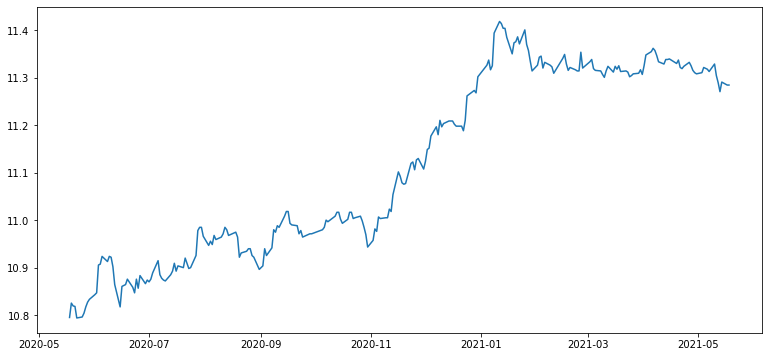

In [6]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

### **STEP 3 : 시계열 안정성 분석**
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

In [7]:
# 구간 통계치(Rolling Statistics) 정의
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

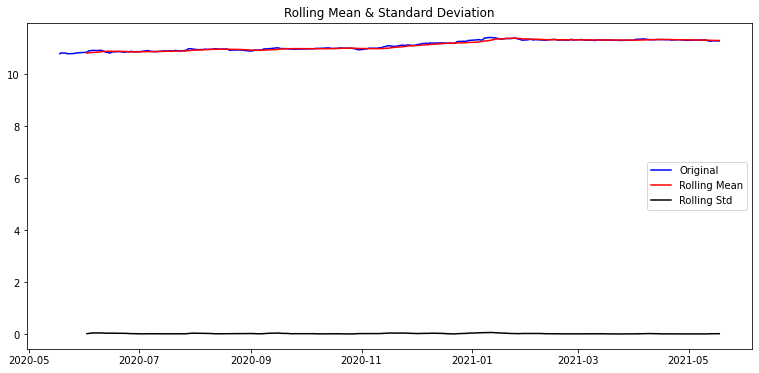

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [9]:
# Augmented Dickey-Fuller Test 정의
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출한다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력한다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


**p-value가 0.05 이상으로 해당 시계열이 안정적인 시계열이라고 할 수 없다.**

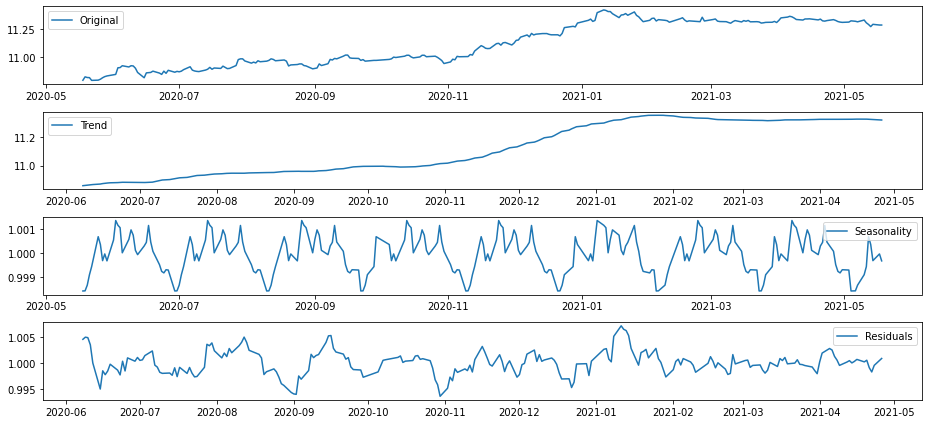

In [11]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [12]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


**압도적으로 낮은 p-value를 보여주고 있으므로 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.**

### **STEP 4 : 학습, 테스트 데이터셋 생성**
* 학습, 테스트 데이터셋 분리

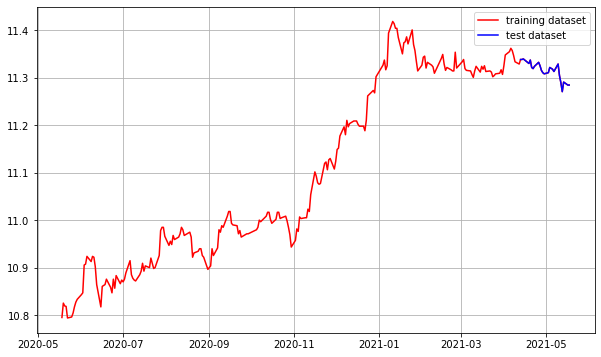

In [13]:
# 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset') # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### **STEP 5 : 적정 ARIMA 모수 찾기**
* ACF, PACF 그려보기 -> p, q 구하기
* 차분 안정성 확인 -> d 구하기

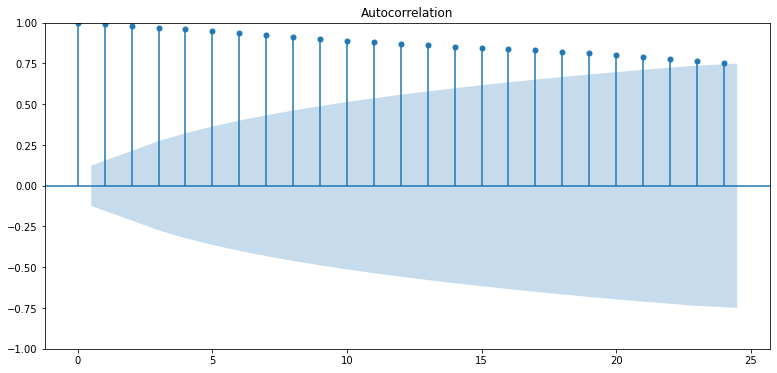

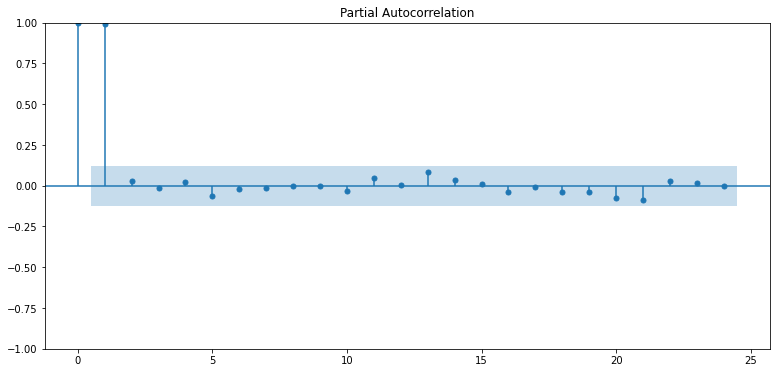

In [14]:
# ACF, PACF 그려보기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log) # ACF: Autocorrelation 그래프 그리기
plot_pacf(ts_log, method='ywm') # PACF: Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 천천히 감소하고 PACF는 lag 1 이후에 급격하게 하락하는 것을 볼 수 있다.
<br>**따라서 AR(1) 모델이 적합할 것으로 보인다.**

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


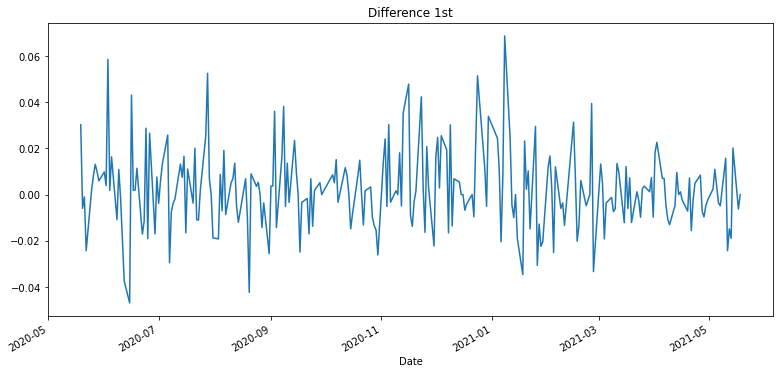

In [15]:
# 1차 차분
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

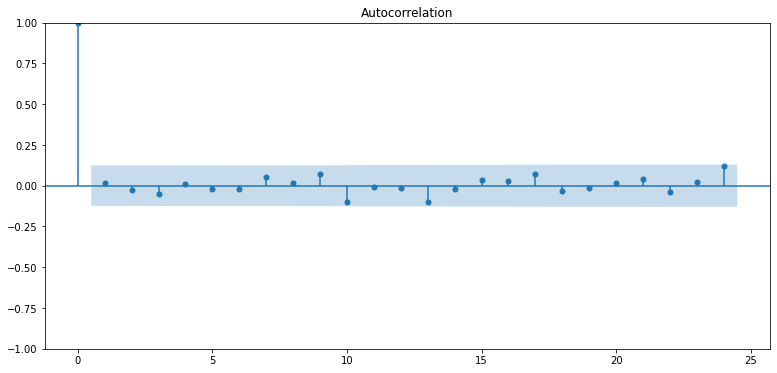

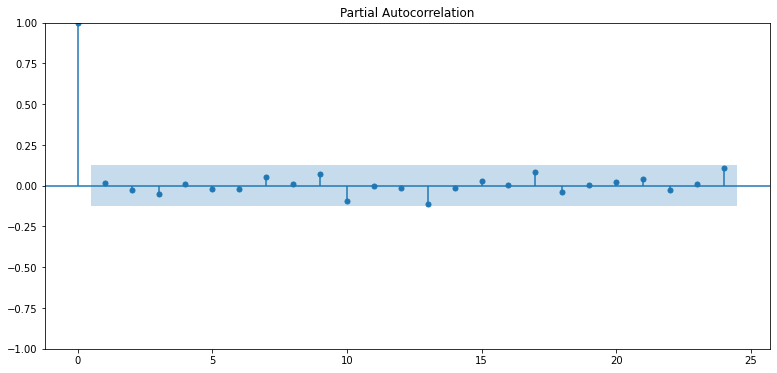

In [16]:
# 1차 차분 ACF, PACF 그려보기
plot_acf(diff_1) # ACF: Autocorrelation 그래프 그리기
plot_pacf(diff_1, method='ywm') # PACF: Partial Autocorrelation 그래프 그리기
plt.show()

1차 차분만으로도 충분히 안정화된 그래프를 확인할 수 있어 2차 차분은 진행하지 않기로 했다.
<br>**ARIMA(1,0,q)와 ARIMA(1,1,q) 모델을 적용시켜보자. (q = 0, q = 1, q = 2)**

### **STEP 6 : ARIMA 모델 훈련과 테스트**
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

#### **ARIMA(1,0,0)**

In [17]:
import warnings
warnings.filterwarnings('ignore') # 경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train Model
model = ARIMA(train_data, order=(1,0,0))
fitted_m = model.fit()
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 583.082
Date:                Sun, 16 Apr 2023   AIC                          -1160.164
Time:                        08:12:45   BIC                          -1149.916
Sample:                             0   HQIC                         -1156.028
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.115     96.195      0.000      10.864      11.316
ar.L1          0.9937      0.006    168.571      0.000       0.982       1.005
sigma2         0.0003   2.45e-05     13.135      0.0

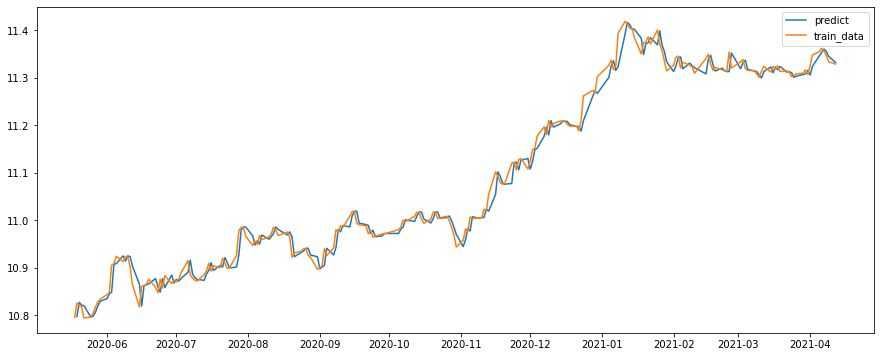

In [18]:
# 훈련 결과 시각화
fitted_m_predict = fitted_m.predict()
fitted_m_predict = fitted_m_predict.drop(fitted_m_predict.index[0])
plt.figure(figsize=(15, 6))
plt.plot(fitted_m_predict, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

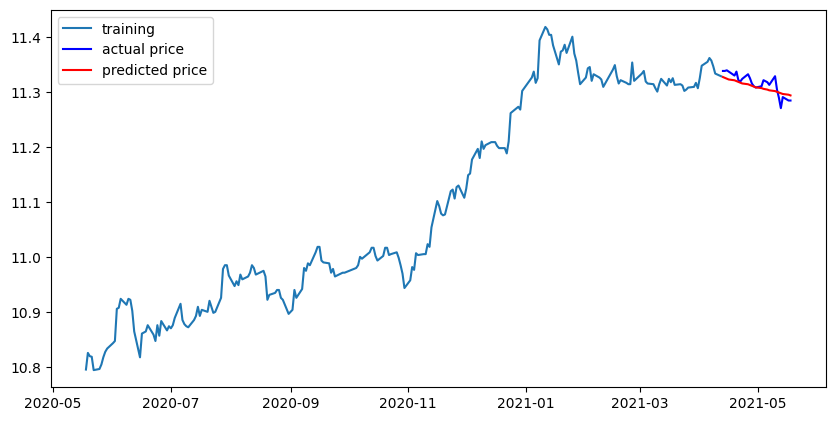

In [19]:
# Forecast: 결과가 fc에 담긴다.
fc = fitted_m.forecast(len(test_data), alpha=0.05) # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index) # 예측결과

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape * 100))

MSE:  1078734.6873192338
MAE:  866.9125685447763
RMSE:  1038.621532281723
MAPE: 1.05%


#### **(추가) 모델 성능 측정 함수 정의**

In [21]:
def arima_result(p,d,q):
    
    # 1. ARIMA 모델 빌드와 훈련
    model = ARIMA(train_data, order=(p,d,q))
    fitted_m = model.fit()
    print(fitted_m.summary())
    
    # 2. ARIMA 모델 훈련 결과 시각화
    fitted_m_predict = fitted_m.predict()
    fitted_m_predict = fitted_m_predict.drop(fitted_m_predict.index[0])
    plt.figure(figsize=(15, 6))
    plt.plot(fitted_m_predict, label='predict')
    plt.plot(train_data, label='train_data')
    plt.legend()
    
    # 3. 모델 테스트 및 플로팅
    # Forecast
    fc = fitted_m.forecast(len(test_data), alpha=0.05) 
    fc = np.array(fc)

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)

    # Plot
    plt.figure(figsize=(10, 5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.legend()
    plt.show()
    
    # 4. 최종 예측 모델 정확도 측정(MAPE)
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data)) / np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape * 100))

#### **ARIMA(1,0,1)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 583.370
Date:                Sun, 16 Apr 2023   AIC                          -1158.741
Time:                        08:12:46   BIC                          -1145.076
Sample:                             0   HQIC                         -1153.226
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.127     87.360      0.000      10.841      11.338
ar.L1          0.9942      0.006    157.934      0.000       0.982       1.007
ma.L1          0.0392      0.063      0.623      0.5

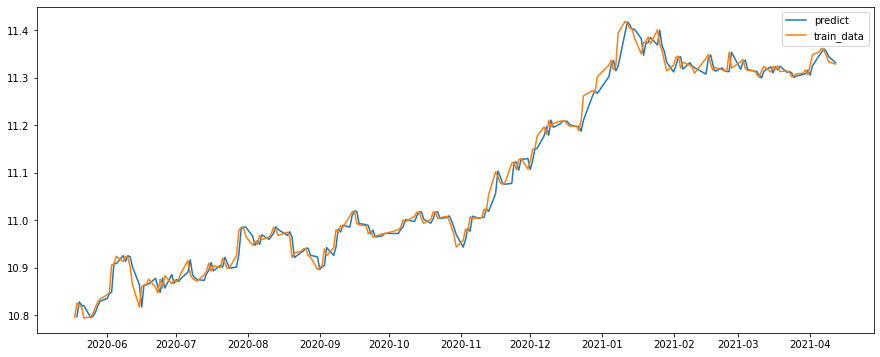

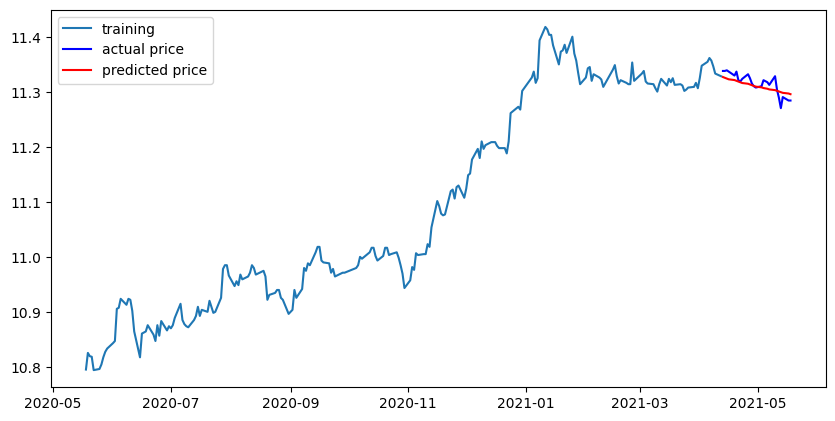

MSE:  1057119.8161340475
MAE:  850.8270312480739
RMSE:  1028.1633217218202
MAPE: 1.04%


In [22]:
arima_result(1,0,1)

#### **ARIMA(1,0,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 583.245
Date:                Sun, 16 Apr 2023   AIC                          -1156.491
Time:                        08:12:47   BIC                          -1139.410
Sample:                             0   HQIC                         -1149.597
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0713      0.109    101.360      0.000      10.857      11.285
ar.L1          0.9933      0.006    157.081      0.000       0.981       1.006
ma.L1          0.0460      0.063      0.729      0.4

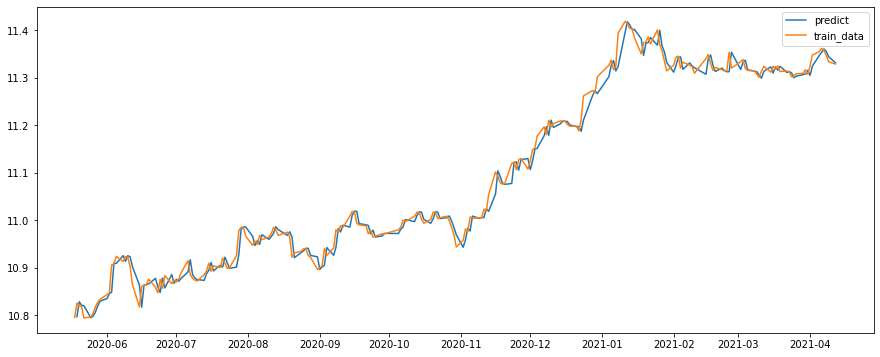

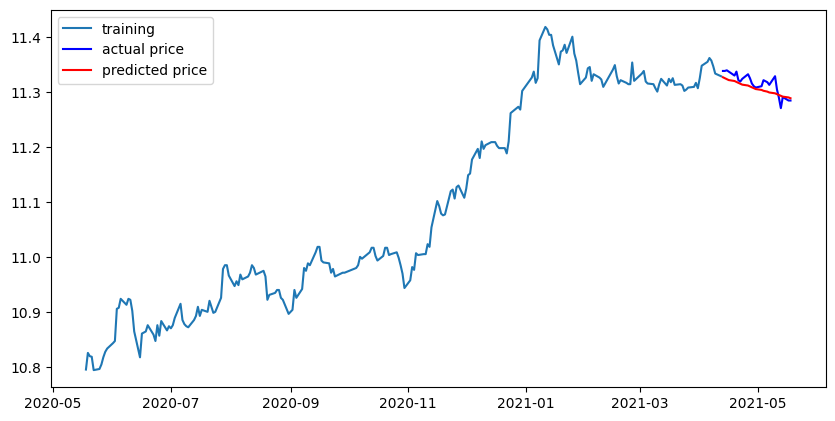

MSE:  1248344.6362079717
MAE:  943.2987087532284
RMSE:  1117.2934423006213
MAPE: 1.14%


In [23]:
arima_result(1,0,2)

#### **ARIMA(1,1,0)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Sun, 16 Apr 2023   AIC                          -1162.976
Time:                        08:12:48   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

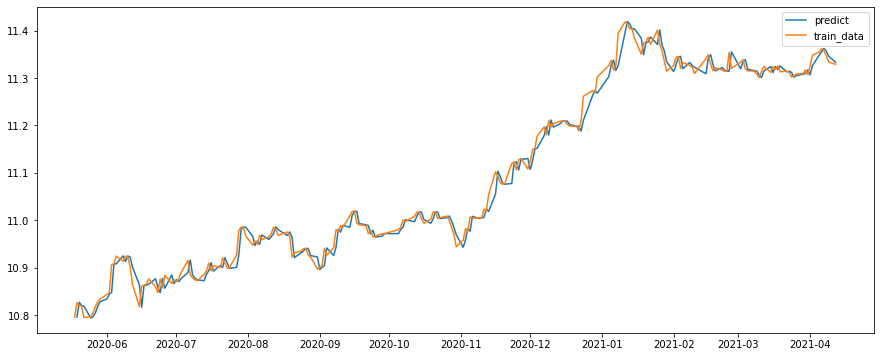

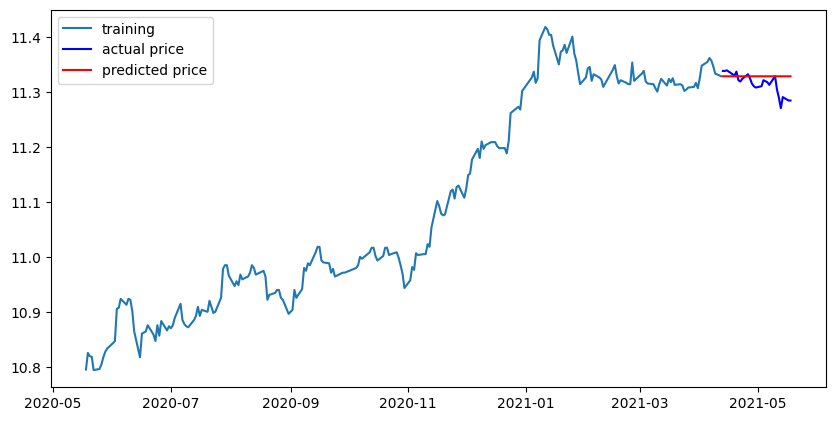

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


In [24]:
arima_result(1,1,0)

#### **ARIMA(1,1,1)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 583.489
Date:                Sun, 16 Apr 2023   AIC                          -1160.979
Time:                        08:12:49   BIC                          -1150.744
Sample:                             0   HQIC                         -1156.847
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0126      2.094      0.006      0.995      -4.092       4.117
ma.L1          0.0237      2.102      0.011      0.991      -4.096       4.143
sigma2         0.0003   2.47e-05     12.936      0.0

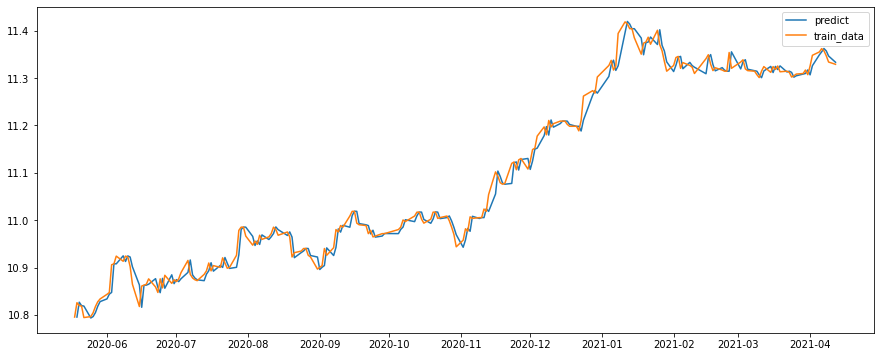

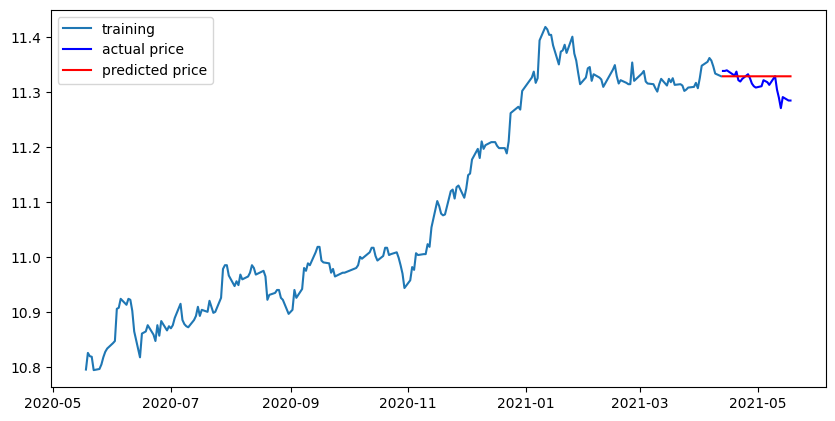

MSE:  3480580.457711579
MAE:  1403.0537770723201
RMSE:  1865.631383127862
MAPE: 1.74%


In [25]:
arima_result(1,1,1)

#### **ARIMA(1,1,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 583.491
Date:                Sun, 16 Apr 2023   AIC                          -1158.981
Time:                        08:12:50   BIC                          -1145.334
Sample:                             0   HQIC                         -1153.473
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2891     45.612     -0.006      0.995     -89.687      89.109
ma.L1          0.3205     45.621      0.007      0.994     -89.096      89.737
ma.L2          0.0105      1.421      0.007      0.9

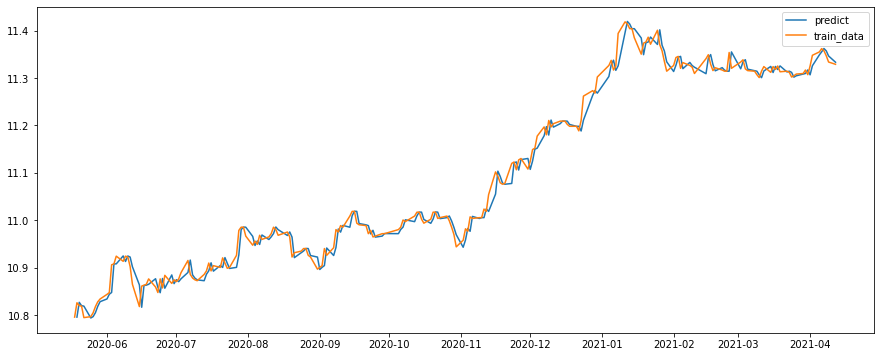

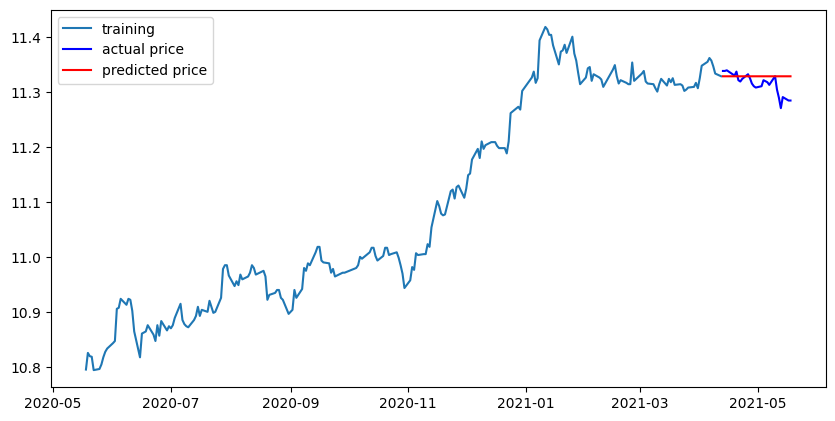

MSE:  3482473.446381117
MAE:  1403.3802095638152
RMSE:  1866.1386460767371
MAPE: 1.74%


In [26]:
arima_result(1,1,2)

#### **ARIMA(2,0,0)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 583.409
Date:                Sun, 16 Apr 2023   AIC                          -1158.817
Time:                        08:12:50   BIC                          -1145.153
Sample:                             0   HQIC                         -1153.302
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.132     83.895      0.000      10.831      11.349
ar.L1          1.0296      0.061     16.764      0.000       0.909       1.150
ar.L2         -0.0350      0.062     -0.562      0.5

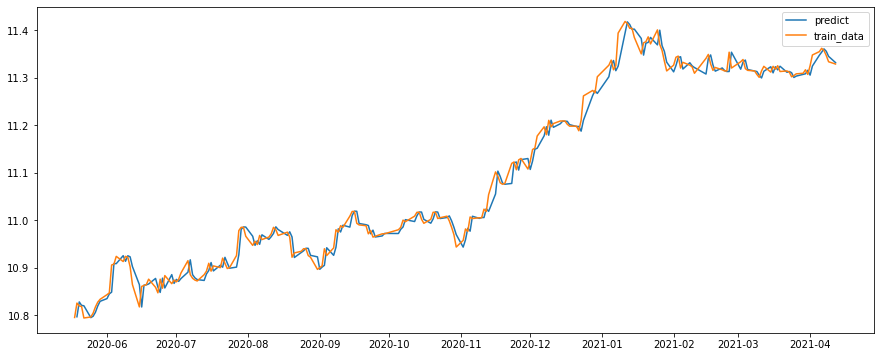

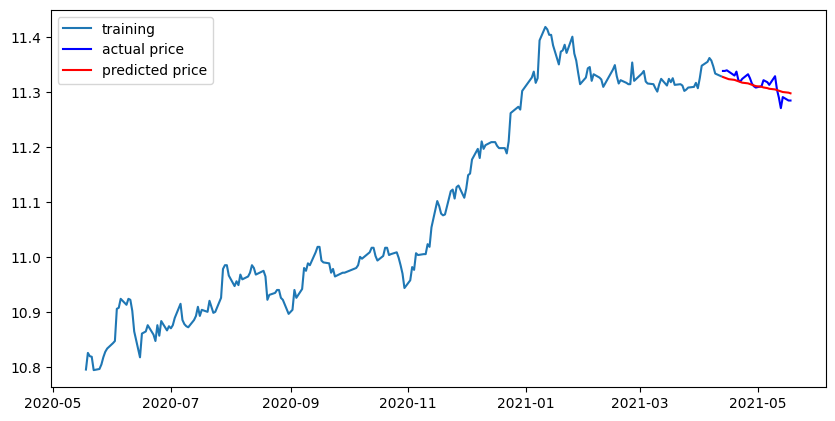

MSE:  1052831.3953688445
MAE:  840.325291750654
RMSE:  1026.0757259427028
MAPE: 1.02%


In [27]:
arima_result(2,0,0)

#### **ARIMA(2,0,1)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Sun, 16 Apr 2023   AIC                          -1156.722
Time:                        08:12:51   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

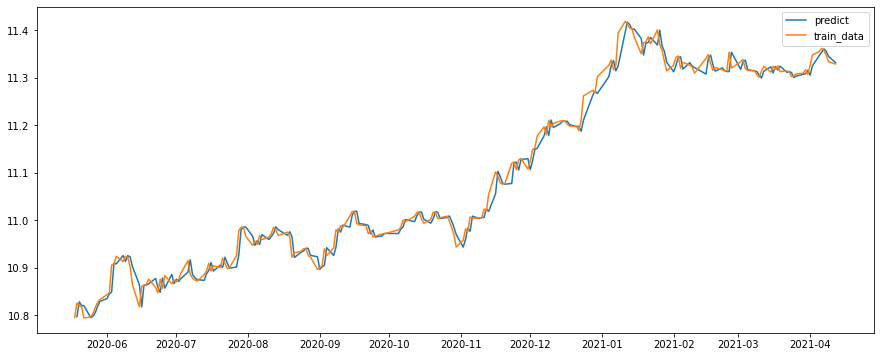

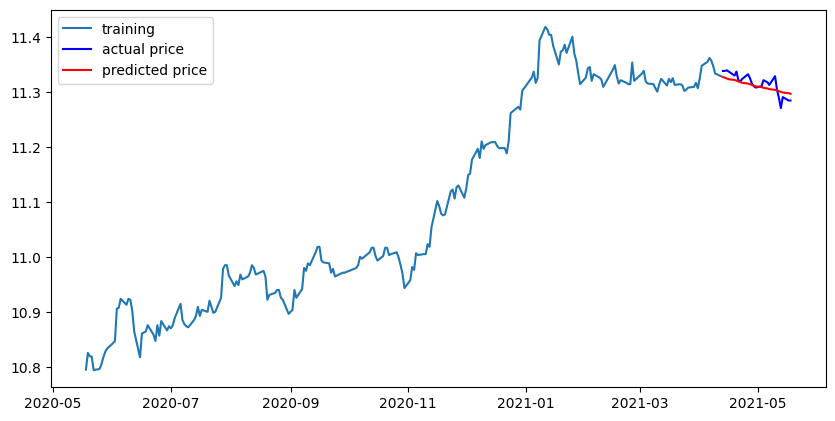

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


In [28]:
arima_result(2,0,1)

#### **ARIMA(2,0,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 583.607
Date:                Sun, 16 Apr 2023   AIC                          -1155.215
Time:                        08:12:53   BIC                          -1134.718
Sample:                             0   HQIC                         -1146.942
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0688      0.196     56.407      0.000      10.684      11.453
ar.L1          0.2660     32.234      0.008      0.993     -62.911      63.443
ar.L2          0.7287     32.134      0.023      0.9

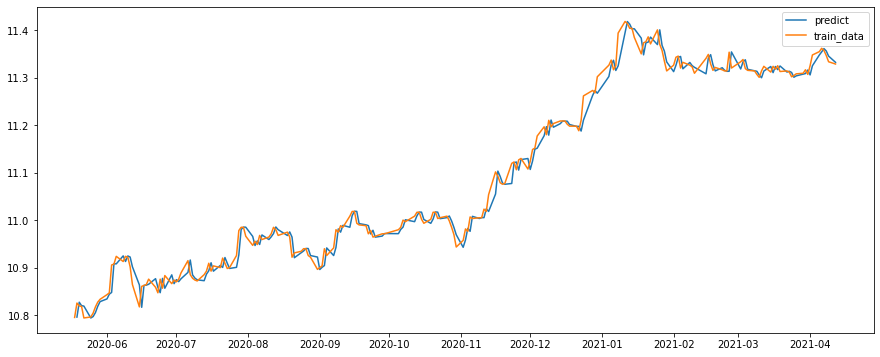

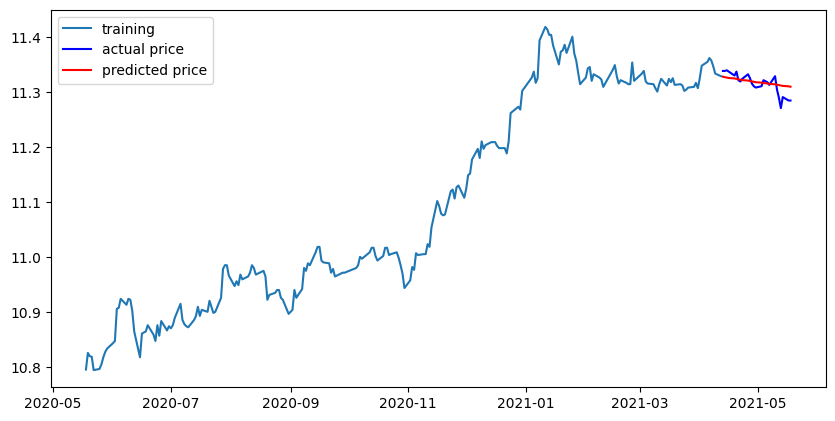

MSE:  1427822.3540262028
MAE:  933.7248352184944
RMSE:  1194.9152078813804
MAPE: 1.15%


In [29]:
arima_result(2,0,2)

|p|d|q|MAPE(%)|
|------|---|---|---|
|1|0|0|1.05|
|1|0|1|1.04|
|1|0|2|1.14|
|1|1|0|1.74|
|1|1|1|1.74|
|1|1|2|1.74|
|2|0|0|1.02|
|2|0|1|1.03|
|2|0|2|1.15|

**ARIMA(2,0,0) 모델이 MAPE 1.02%로 가장 성능이 좋은 것을 확인할 수 있다.**

### **STEP 7 : 다른 주식 종목 예측해 보기**
* 관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### **APPLE 🍎**
#### **1. 시계열 데이터 준비** 

In [30]:
# 데이터 불러와서 데이터프레임으로 변환
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-12,168.020004,169.869995,166.639999,167.660004,166.650482,79265200
2022-04-13,167.389999,171.039993,166.770004,170.399994,169.373962,70618900
2022-04-14,170.619995,171.270004,165.039993,165.289993,164.294754,75329400
2022-04-18,163.919998,166.600006,163.570007,165.070007,164.076080,69023900
2022-04-19,165.020004,167.820007,163.910004,167.399994,166.392044,67723800


In [31]:
# Time Series 생성
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2022-04-12    167.660004
2022-04-13    170.399994
2022-04-14    165.289993
2022-04-18    165.070007
2022-04-19    167.399994
Name: Close, dtype: float64

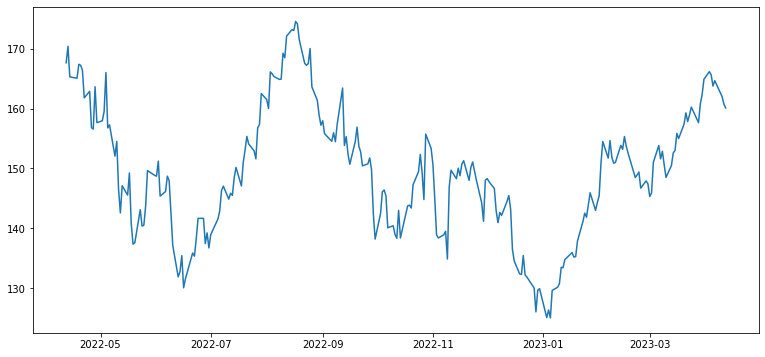

In [32]:
# 데이터 시각화
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

#### **2. 각종 전처리 수행**

In [33]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

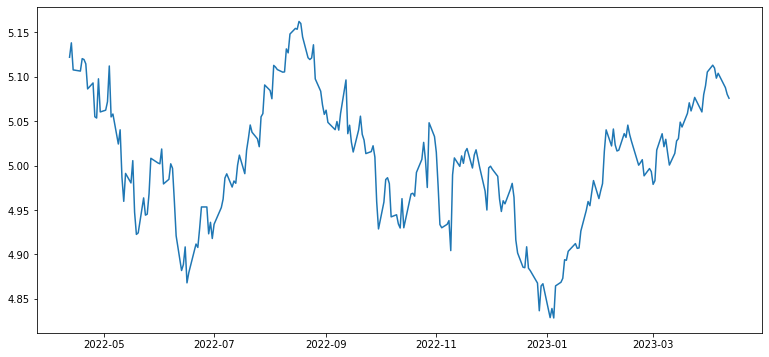

In [34]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

#### **3. 시계열 안정성 분석**

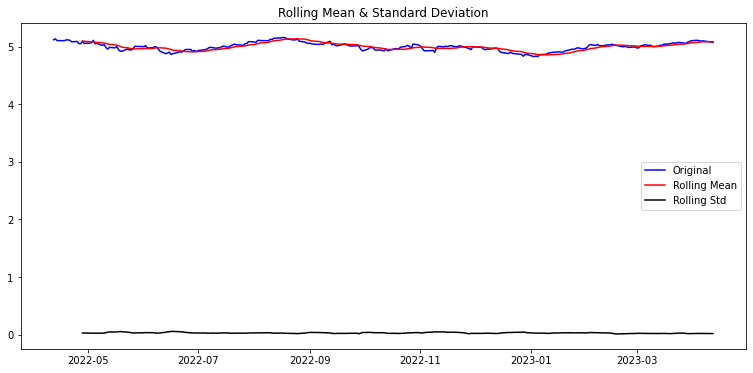

Results of Dickey-Fuller Test:
Test Statistic                  -2.588455
p-value                          0.095407
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


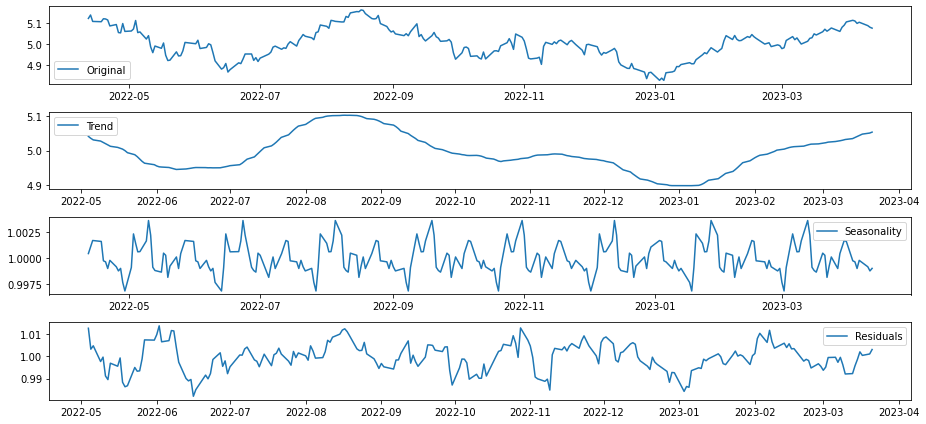

In [35]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [36]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.036794
p-value                          0.000019
#Lags Used                       5.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


p-value가 0.05보다 작으므로 residual이 autocorrelation을 가지고 있다고 해석할 수 있다.
<br>**따라서 residual의 안정성이 괜찮다고 판단할 수 있다.**

#### **4. 학습, 테스트 데이터셋 생성**

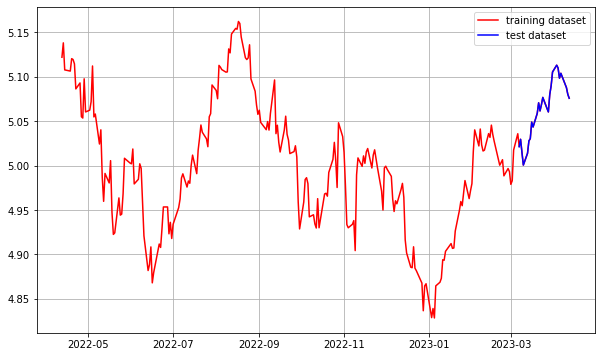

In [37]:
# 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### **5. 적정 ARIMA 모수 찾기**

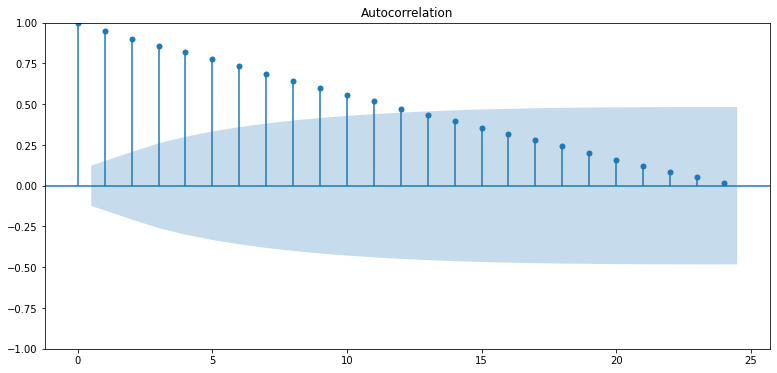

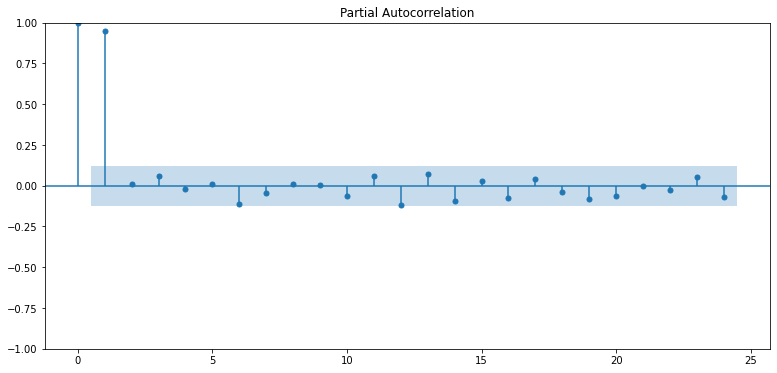

In [38]:
# ACF, PACF 그려보기
plot_acf(ts_log)  
plot_pacf(ts_log, method='ywm')
plt.show()

ACF가 천천히 감소하고 PACF가 lag 1 이후 급격하게 하락하는 패턴으로 AR 모델의 적합성을 나타낸다.
<br>**이전과 마찬가지로 AR(1) 모델이 가장 적합할 것으로 예상된다.**

Results of Dickey-Fuller Test:
Test Statistic                -1.676274e+01
p-value                        1.306116e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


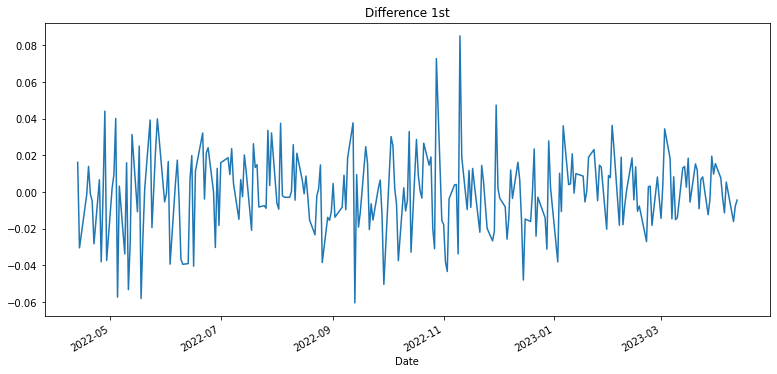

In [39]:
# 1차 차분
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

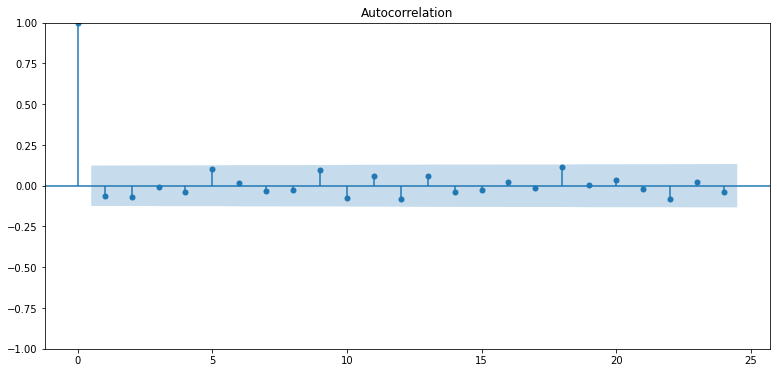

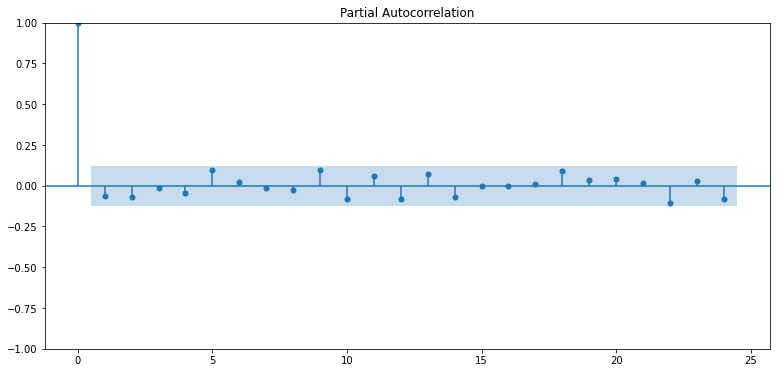

In [40]:
# 1차 차분 ACF, PACF 그려보기
plot_acf(diff_1) # ACF: Autocorrelation 그래프 그리기
plot_pacf(diff_1, method='ywm') # PACF: Partial Autocorrelation 그래프 그리기
plt.show()

**ARIMA(1,1,0)으로 시작해서 값을 하나씩 변경해보며 적당한 모수를 찾아보도록 하자!**

#### **6. ARIMA 모델 훈련과 테스트**

#### **ARIMA(1,1,0)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 531.635
Date:                Sun, 16 Apr 2023   AIC                          -1059.270
Time:                        08:12:57   BIC                          -1052.446
Sample:                             0   HQIC                         -1056.516
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0654      0.065     -1.011      0.312      -0.192       0.061
sigma2         0.0005   4.48e-05     11.342      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.01   Jarque-

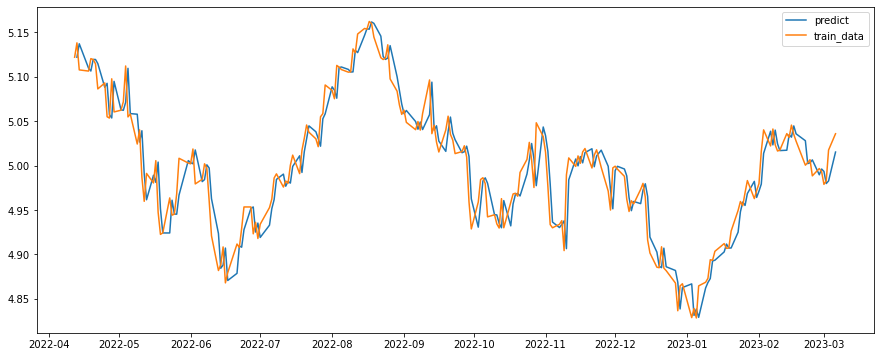

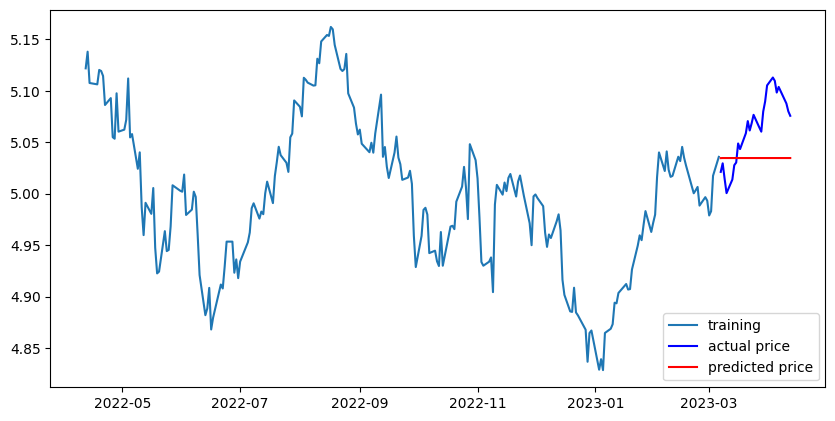

MSE:  44.97477939865693
MAE:  5.698108810499951
RMSE:  6.706323836399263
MAPE: 3.55%


In [41]:
arima_result(1,1,0)

#### **ARIMA(1,1,1)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 531.921
Date:                Sun, 16 Apr 2023   AIC                          -1057.843
Time:                        08:12:57   BIC                          -1047.608
Sample:                             0   HQIC                         -1053.712
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6199      0.388      1.597      0.110      -0.141       1.380
ma.L1         -0.6885      0.361     -1.910      0.056      -1.395       0.018
sigma2         0.0005   4.46e-05     11.363      0.0

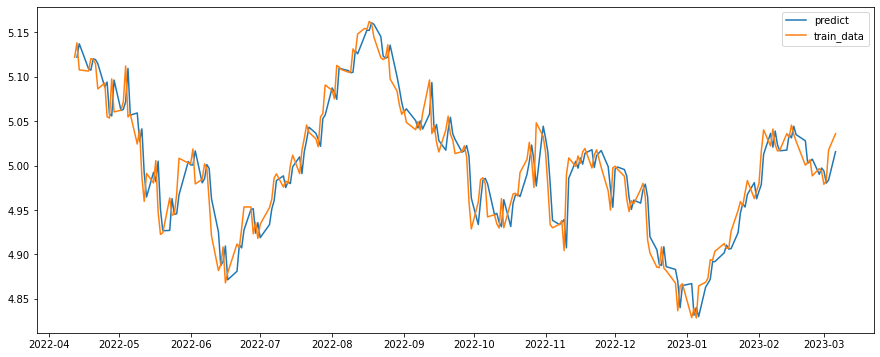

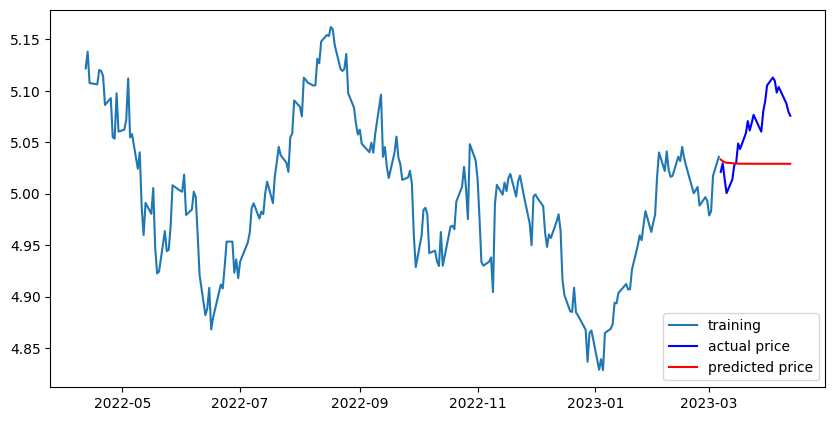

MSE:  53.54599433771054
MAE:  6.165986107208236
RMSE:  7.317512851899239
MAPE: 3.83%


In [42]:
arima_result(1,1,1)

#### **ARIMA(1,1,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 532.306
Date:                Sun, 16 Apr 2023   AIC                          -1056.612
Time:                        08:12:58   BIC                          -1042.965
Sample:                             0   HQIC                         -1051.104
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3741      0.743     -0.503      0.615      -1.831       1.083
ma.L1          0.3022      0.737      0.410      0.682      -1.142       1.747
ma.L2         -0.1027      0.068     -1.511      0.1

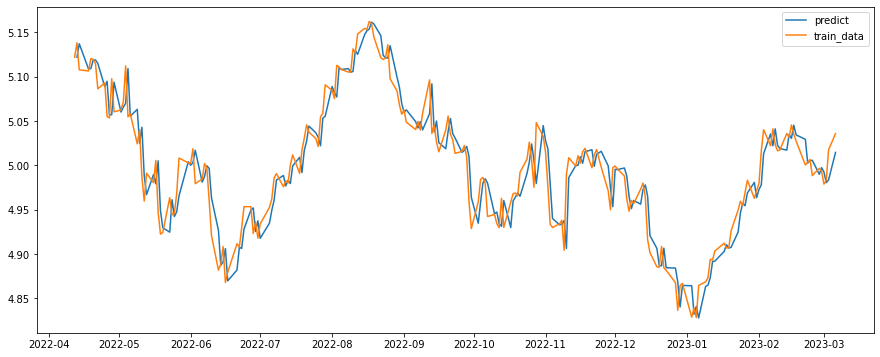

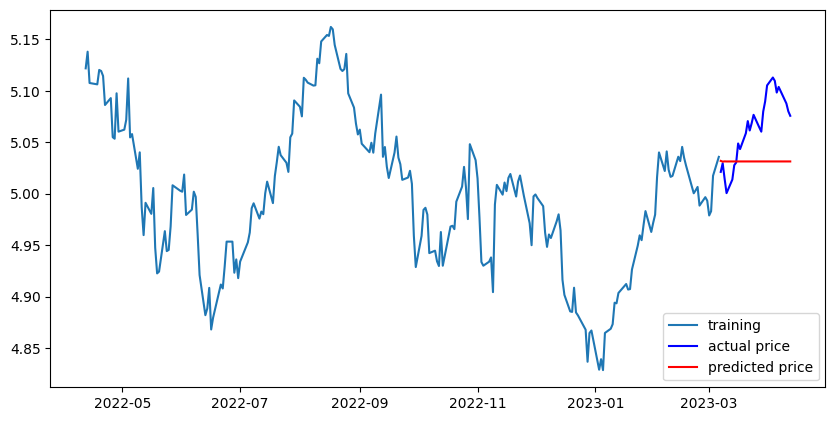

MSE:  49.7918260497391
MAE:  5.935540163327032
RMSE:  7.056332336967917
MAPE: 3.69%


In [43]:
arima_result(1,1,2)

#### **ARIMA(1,2,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 2)   Log Likelihood                 529.061
Date:                Sun, 16 Apr 2023   AIC                          -1050.121
Time:                        08:13:00   BIC                          -1036.492
Sample:                             0   HQIC                         -1044.619
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9117      0.039    -23.381      0.000      -0.988      -0.835
ma.L1         -0.0102      5.381     -0.002      0.998     -10.556      10.536
ma.L2         -0.9897      5.325     -0.186      0.8

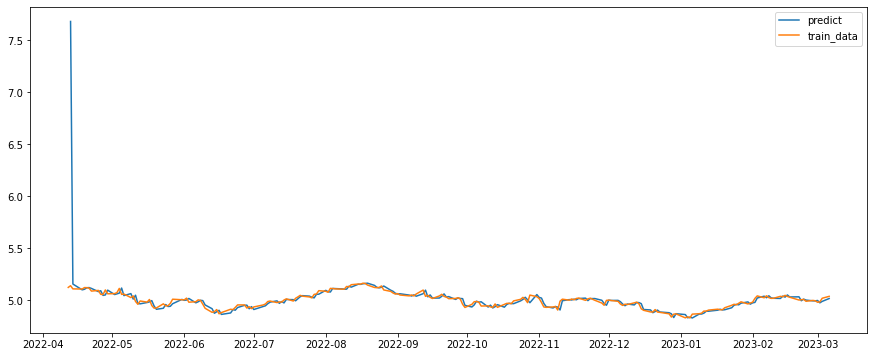

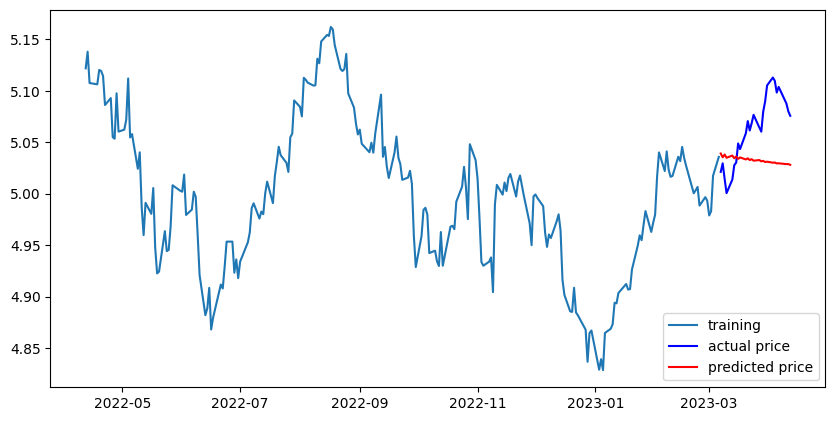

MSE:  51.5833267891702
MAE:  6.129258179646261
RMSE:  7.182153353220063
MAPE: 3.82%


In [44]:
arima_result(1,2,2)

predicted price와 actual price의 선이 굉장히 어긋난 것을 확인할 수 있다.
<br>MAPE 점수에는 큰 차이가 없는데 그래프에서는 큰 차이가 보이는 이유는 뭘까...?
<br>ARIMA(1,1,1)보다 MAPE가 0.01% 적게 나왔는데도 그래프의 선은 더 맞지 않는다.

#### **ARIMA(1,3,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 3, 2)   Log Likelihood                 516.613
Date:                Sun, 16 Apr 2023   AIC                          -1025.227
Time:                        08:13:01   BIC                          -1011.616
Sample:                             0   HQIC                         -1019.731
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0603      0.071     -0.849      0.396      -0.200       0.079
ma.L1         -1.9897      0.270     -7.371      0.000      -2.519      -1.461
ma.L2          0.9898      0.267      3.714      0.0

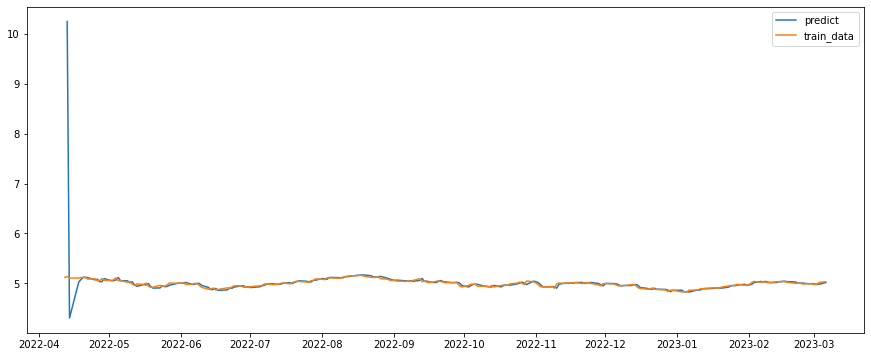

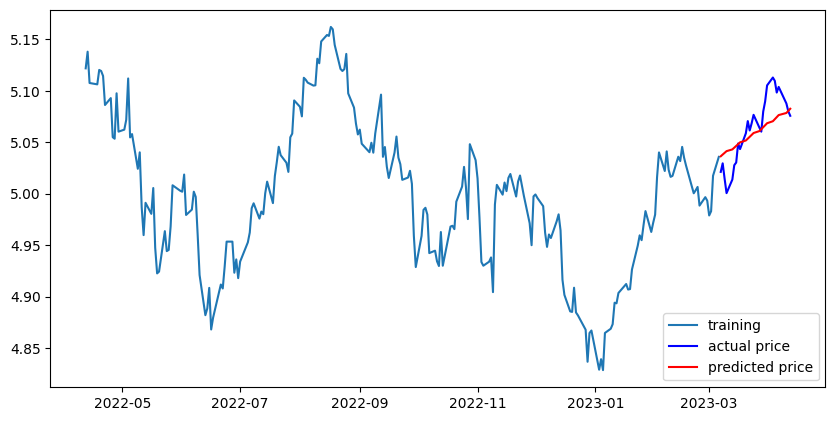

MSE:  11.280048020873789
MAE:  2.7202727421941493
RMSE:  3.3585782737452745
MAPE: 1.71%


In [45]:
arima_result(1,3,2)

d = 3으로 올려줬더니 MAPE가 2% 떨어졌고 그래프도 제법 그럴싸해 보인다 😀

#### **ARIMA(1,3,3)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 3, 3)   Log Likelihood                 519.507
Date:                Sun, 16 Apr 2023   AIC                          -1029.014
Time:                        08:13:03   BIC                          -1012.001
Sample:                             0   HQIC                         -1022.145
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9204      0.037    -24.601      0.000      -0.994      -0.847
ma.L1         -0.9787      0.530     -1.847      0.065      -2.018       0.060
ma.L2         -0.9992      1.017     -0.982      0.3

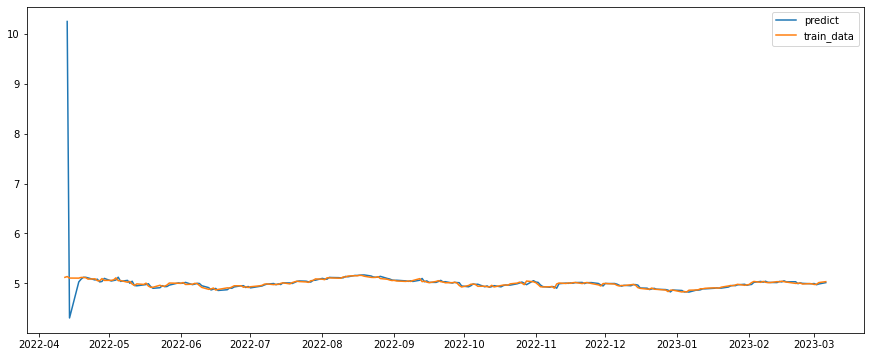

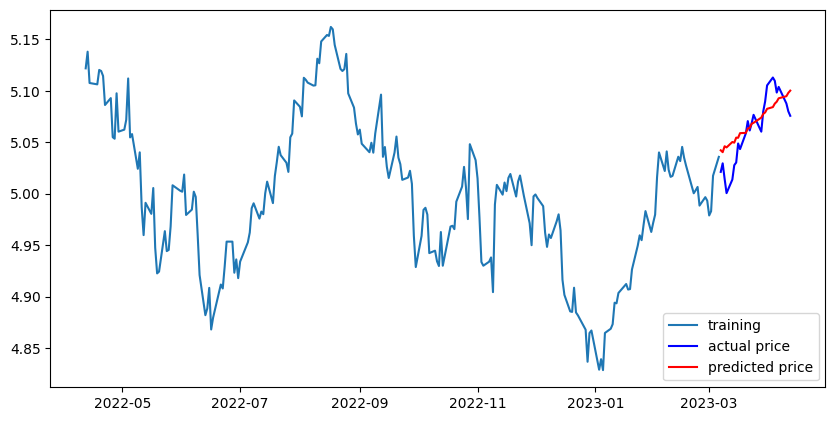

MSE:  9.159012507235818
MAE:  2.474708102610008
RMSE:  3.0263860472906985
MAPE: 1.58%


In [46]:
arima_result(1,3,3)

|p|d|q|MAPE(%)|
|------|---|---|---|
|1|1|0|3.55|
|1|1|1|3.83|
|1|1|2|3.69|
|1|2|2|3.82|
|1|3|2|1.71|
|1|3|3|1.58|

**ARIMA(1,3,3) 모델이 MAPE 1.58%로 가장 좋은 성능을 보여준다.**

### **JPMorgan**
#### **1. 시계열 데이터 준비** 

In [47]:
# 데이터 불러와서 데이터프레임으로 변환
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/JPM.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-04-18,125.669998,129.240005,125.540001,128.460007,124.303581,11834400
2022-04-19,128.449997,131.320007,128.229996,131.119995,126.877502,15015400
2022-04-20,132.520004,133.509995,131.339996,131.580002,127.322639,13430200
2022-04-21,132.220001,132.809998,129.960007,130.559998,126.335632,12174200
2022-04-22,130.279999,130.520004,126.690002,126.809998,122.706970,14318800


In [48]:
# Time Series 생성
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2022-04-18    128.460007
2022-04-19    131.119995
2022-04-20    131.580002
2022-04-21    130.559998
2022-04-22    126.809998
Name: Close, dtype: float64

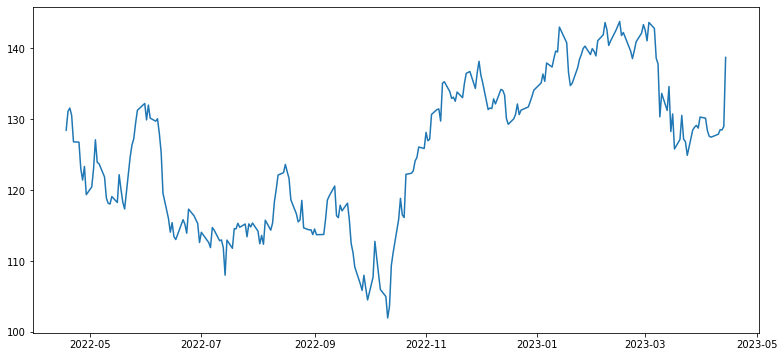

In [49]:
# 데이터 시각화
rcParams['figure.figsize'] = 13, 6
plt.plot(ts)

#### **2. 각종 전처리 수행**

In [50]:
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

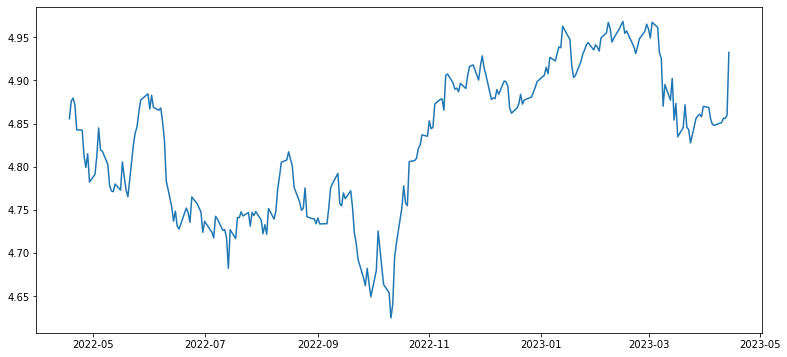

In [51]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

#### **3. 시계열 안정성 분석**

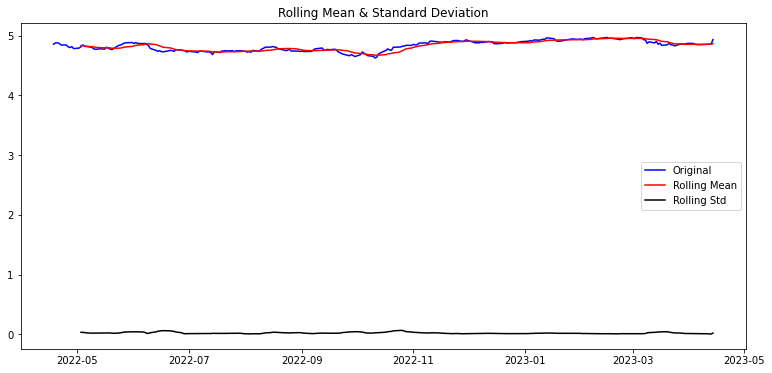

Results of Dickey-Fuller Test:
Test Statistic                  -1.515639
p-value                          0.525761
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


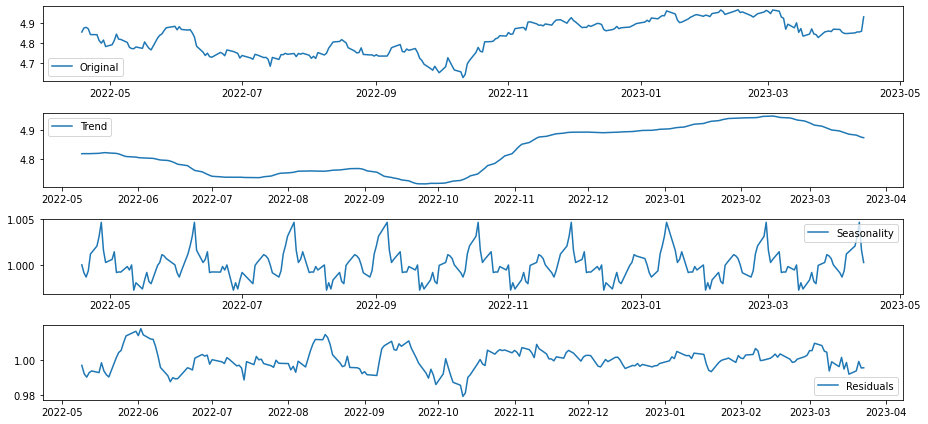

In [52]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [53]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.972020
p-value                          0.000025
#Lags Used                       2.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


#### **4. 학습, 테스트 데이터셋 생성**

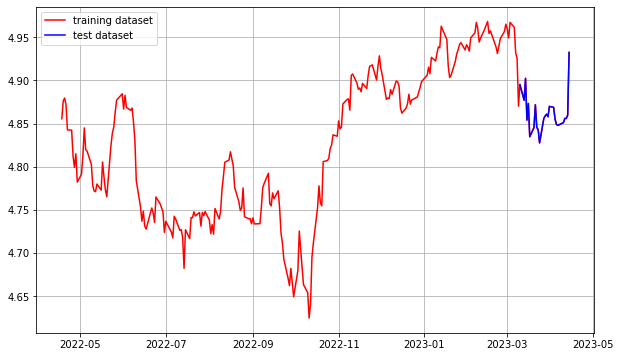

In [54]:
# 데이터셋 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### **5. 적정 ARIMA 모수 찾기**

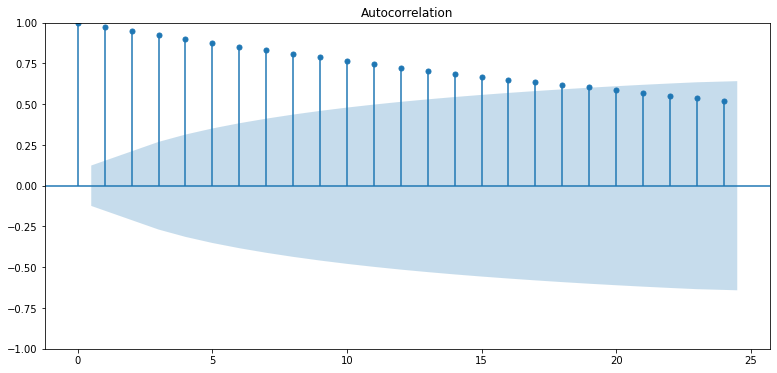

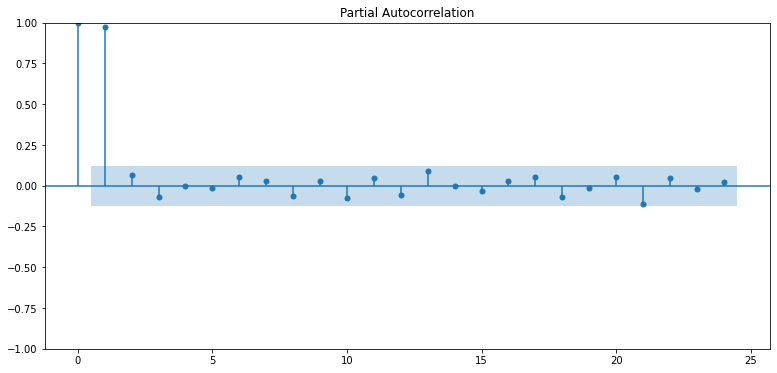

In [55]:
# ACF, PACF 그려보기
plot_acf(ts_log)  
plot_pacf(ts_log, method='ywm')
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.531059e+01
p-value                        4.191708e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


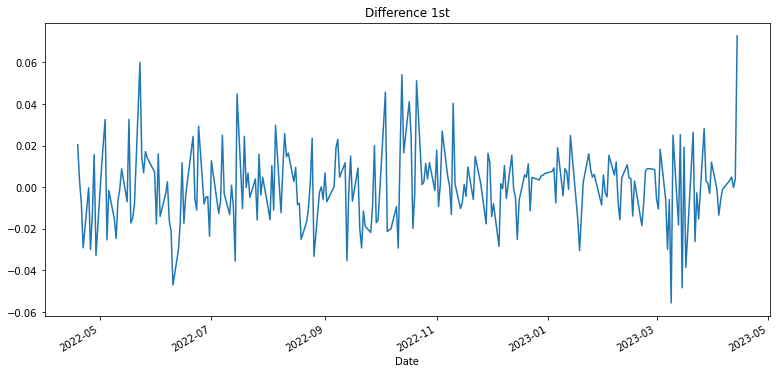

In [56]:
# 1차 차분
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

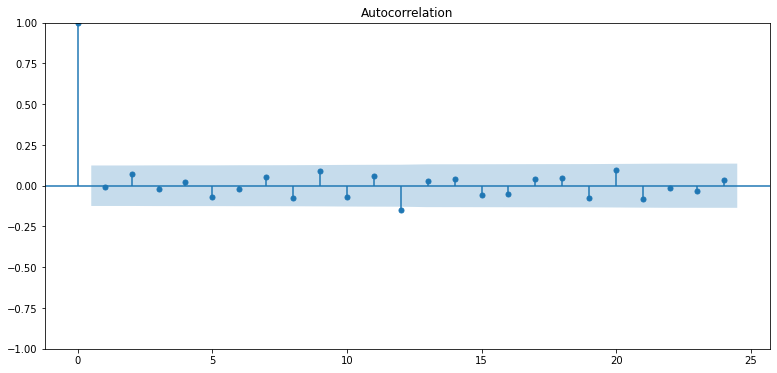

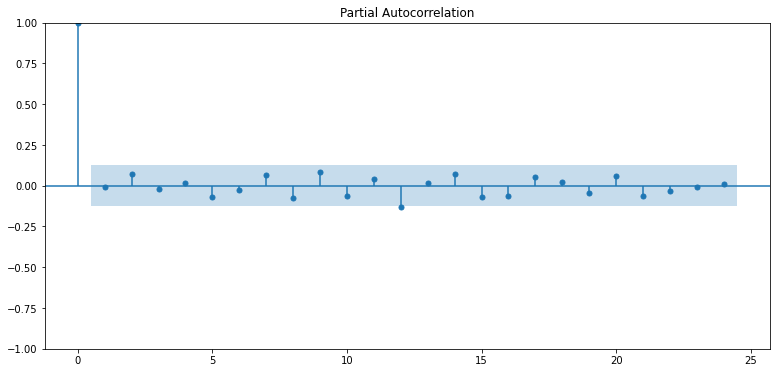

In [57]:
# 1차 차분 ACF, PACF 그려보기
plot_acf(diff_1)
plot_pacf(diff_1, method='ywm')
plt.show()

2차 차분까지 진행 안 해도 될 것 같지만 궁금하니깐 한번 해보기로 했다.

Results of Dickey-Fuller Test:
Test Statistic                -7.225428e+00
p-value                        2.059048e-10
#Lags Used                     1.200000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


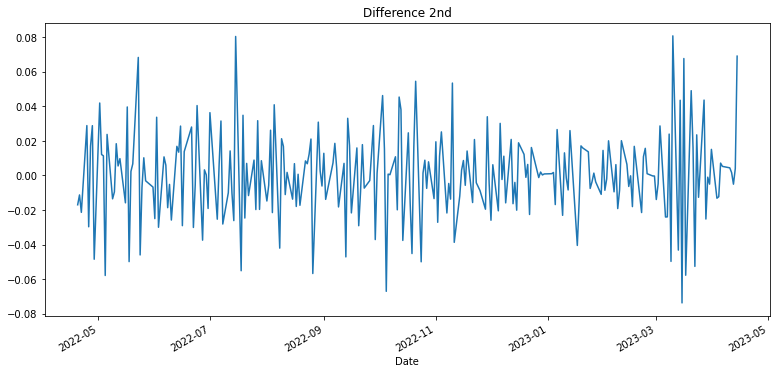

In [58]:
# 2차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

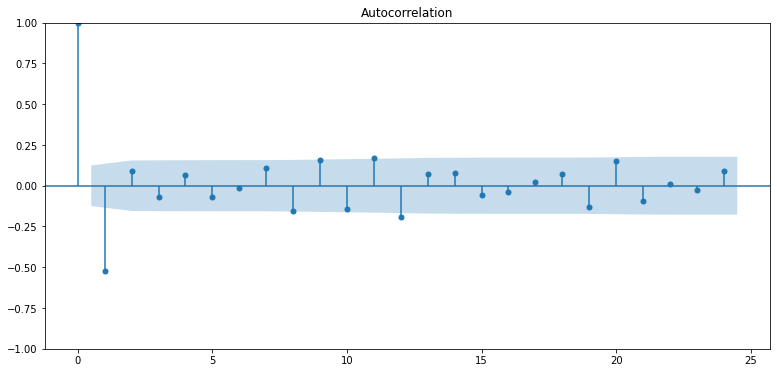

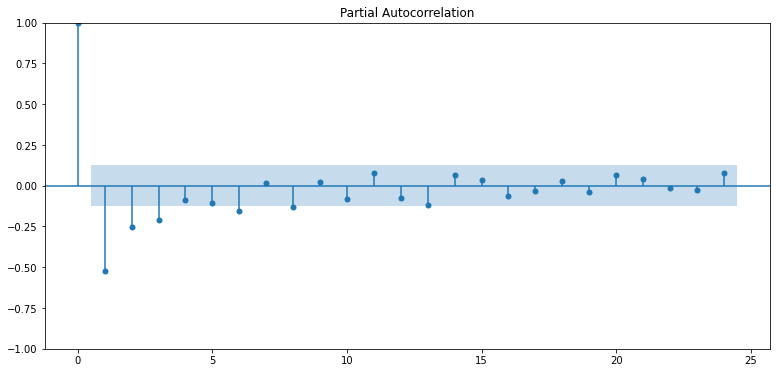

In [59]:
# 2차 차분 ACF, PACF 그려보기
plot_acf(diff_2)
plot_pacf(diff_2, method='ywm')
plt.show()

2차 차분을 해본 결과, PACF를 확인해보면 boundary를 넘어가는 값들이 생긴 것을 확인할 수 있다.
<br>**ARIMA(1,0,q)와 ARIMA(1,1,q) 모델을 적용시켜 값을 바꿔가며 모델의 예측 능력을 확인해보도록 하자.**

#### **6. ARIMA 모델 훈련과 테스트**

#### **ARIMA(1,0,0)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 590.076
Date:                Sun, 16 Apr 2023   AIC                          -1174.152
Time:                        08:13:08   BIC                          -1163.904
Sample:                             0   HQIC                         -1170.016
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8243      0.062     78.202      0.000       4.703       4.945
ar.L1          0.9800      0.014     70.360      0.000       0.953       1.007
sigma2         0.0003   2.67e-05     11.386      0.0

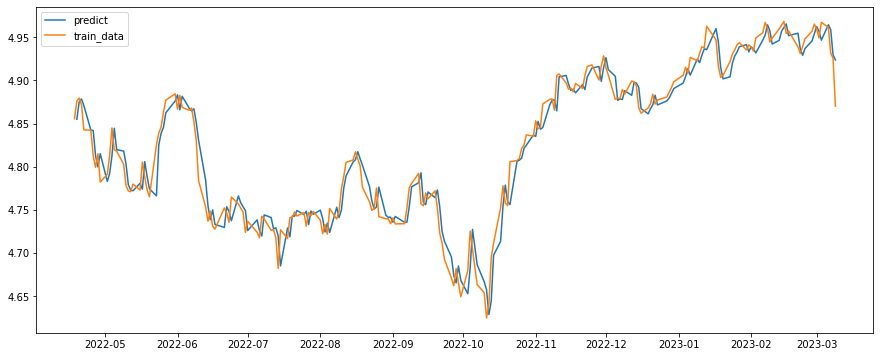

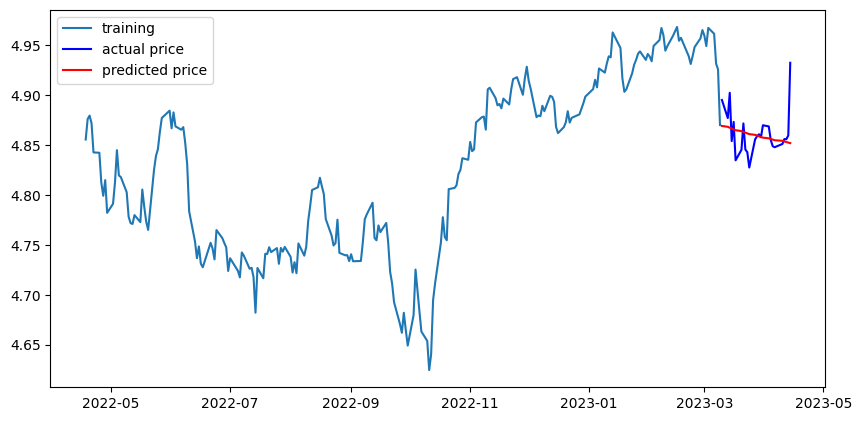

MSE:  8.47666781586344
MAE:  1.8677320590753124
RMSE:  2.911471761131033
MAPE: 1.42%


In [60]:
arima_result(1,0,0)

#### **ARIMA(1,0,1)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 591.008
Date:                Sun, 16 Apr 2023   AIC                          -1174.017
Time:                        08:13:08   BIC                          -1160.352
Sample:                             0   HQIC                         -1168.502
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8336      0.058     83.641      0.000       4.720       4.947
ar.L1          0.9757      0.015     64.856      0.000       0.946       1.005
ma.L1          0.0867      0.069      1.265      0.2

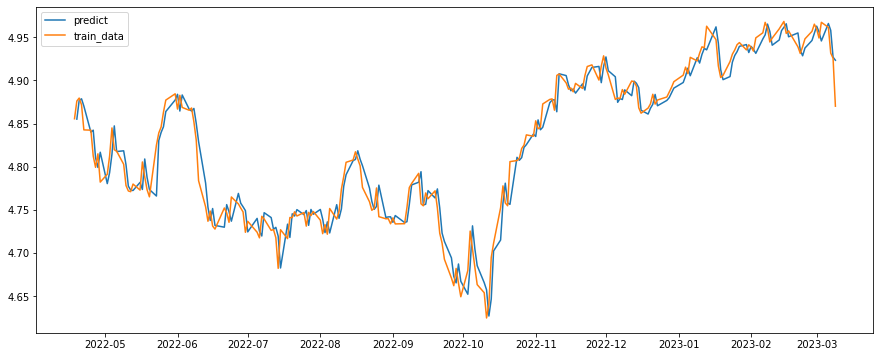

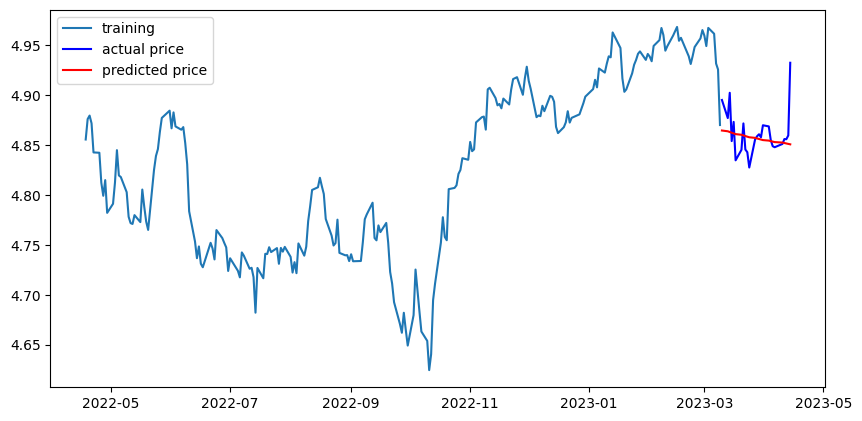

MSE:  8.694237742239123
MAE:  1.9067198250662756
RMSE:  2.9485992847857645
MAPE: 1.45%


In [61]:
arima_result(1,0,1)

#### **ARIMA(1,0,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 591.169
Date:                Sun, 16 Apr 2023   AIC                          -1172.338
Time:                        08:13:10   BIC                          -1155.258
Sample:                             0   HQIC                         -1165.445
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8329      0.057     84.438      0.000       4.721       4.945
ar.L1          0.9744      0.016     62.015      0.000       0.944       1.005
ma.L1          0.0874      0.068      1.279      0.2

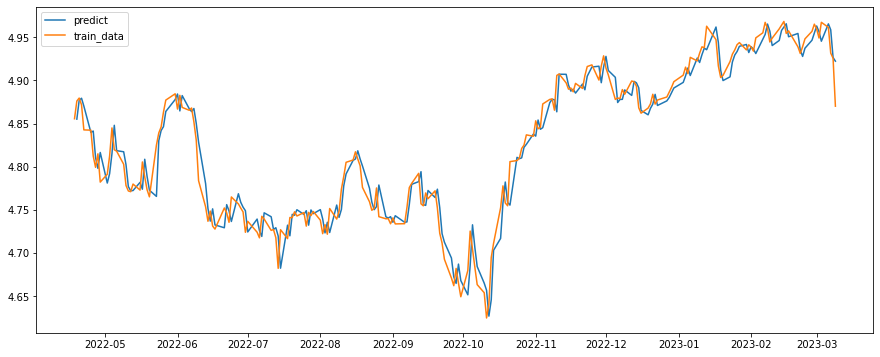

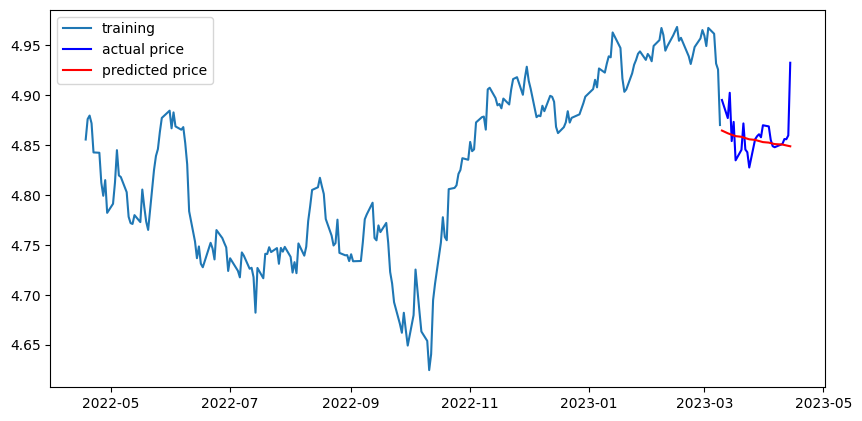

MSE:  9.010290703203898
MAE:  1.9592823481744142
RMSE:  3.0017146272095716
MAPE: 1.49%


In [62]:
arima_result(1,0,2)

#### **ARIMA(1,1,0)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 588.249
Date:                Sun, 16 Apr 2023   AIC                          -1172.498
Time:                        08:13:10   BIC                          -1165.675
Sample:                             0   HQIC                         -1169.744
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0824      0.066      1.241      0.215      -0.048       0.212
sigma2         0.0003   2.38e-05     12.850      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

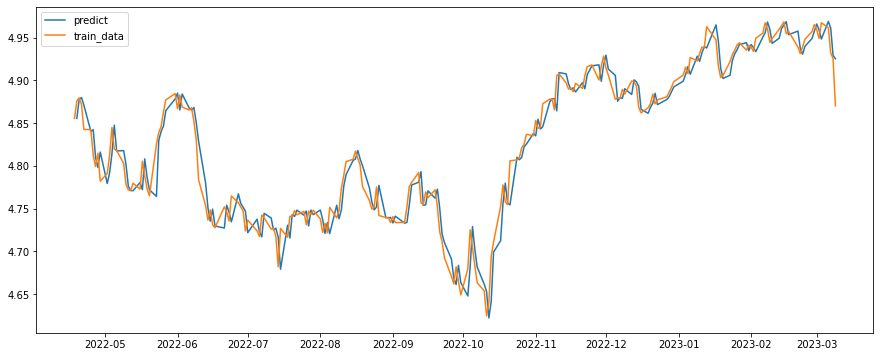

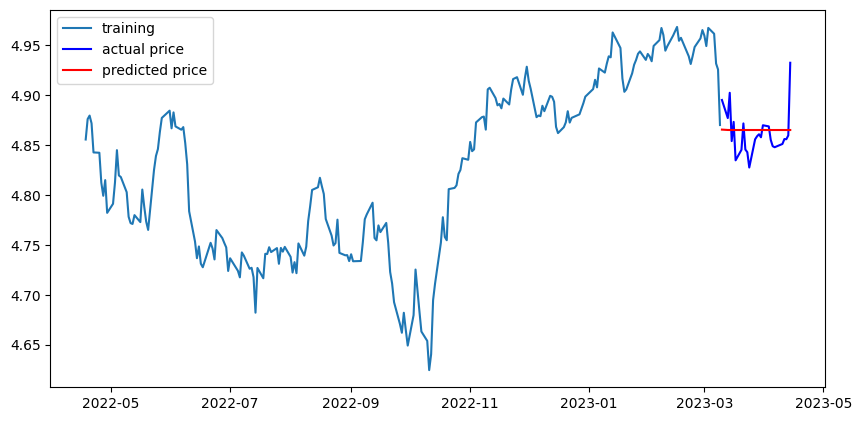

MSE:  8.308872023959841
MAE:  2.175084518234119
RMSE:  2.8825114091638633
MAPE: 1.67%


In [63]:
arima_result(1,1,0)

#### **ARIMA(1,1,1)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 588.271
Date:                Sun, 16 Apr 2023   AIC                          -1170.542
Time:                        08:13:11   BIC                          -1160.307
Sample:                             0   HQIC                         -1166.411
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5552      0.485      1.144      0.253      -0.396       1.507
ma.L1         -0.4760      0.509     -0.936      0.349      -1.473       0.521
sigma2         0.0003   2.38e-05     12.876      0.0

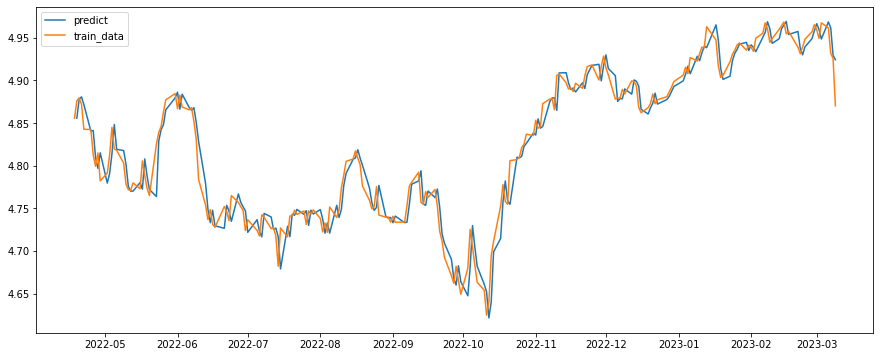

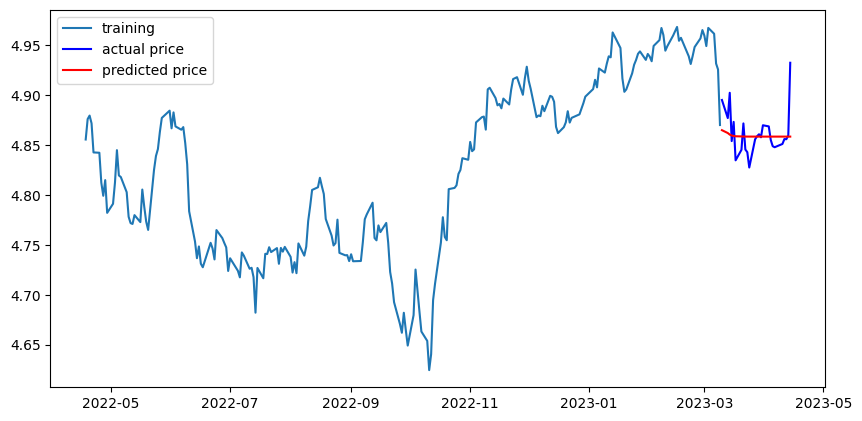

MSE:  7.931423147199044
MAE:  1.8531980152377816
RMSE:  2.8162782439238927
MAPE: 1.41%


In [64]:
arima_result(1,1,1)

#### **ARIMA(1,1,2)**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 588.259
Date:                Sun, 16 Apr 2023   AIC                          -1168.519
Time:                        08:13:12   BIC                          -1154.872
Sample:                             0   HQIC                         -1163.010
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6347      1.564      0.406      0.685      -2.431       3.701
ma.L1         -0.5543      1.550     -0.358      0.721      -3.592       2.484
ma.L2         -0.0316      0.170     -0.186      0.8

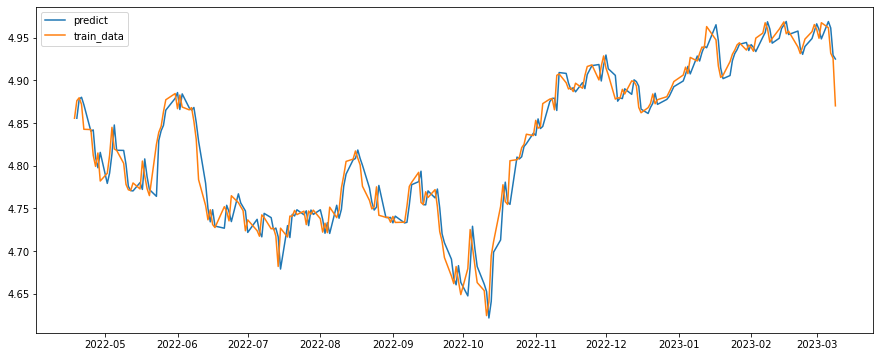

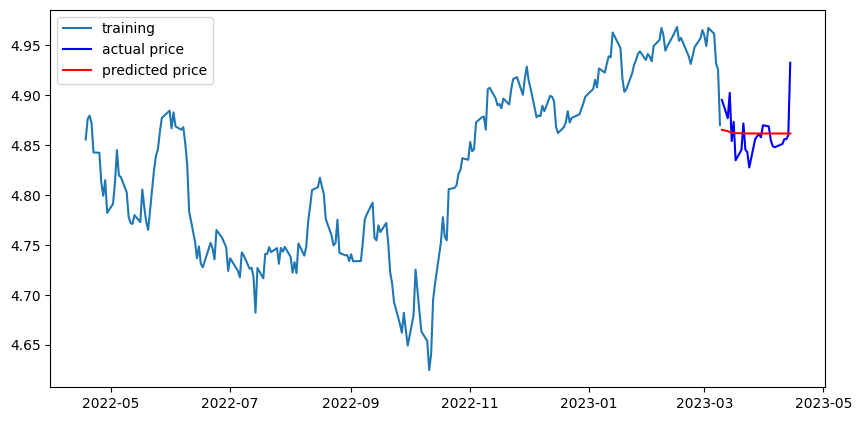

MSE:  7.929196810181704
MAE:  1.9817633807371822
RMSE:  2.8158829539207955
MAPE: 1.51%


In [65]:
arima_result(1,1,2)

|p|d|q|MAPE(%)|
|------|---|---|---|
|1|0|0|1.42|
|1|0|1|1.45|
|1|0|2|1.49|
|1|1|0|1.67|
|1|1|1|1.41|
|1|1|2|1.51|

**ARIMA(1,1,1) 모델이 MAPE 1.41%로 성능이 가장 좋은 것을 확인할 수 있다.**

**최종 정리**

||ARIMA(p,d,q)|MAPE(%)|
|------|---|---|
|Samsung|(2,0,0)|1.02|
|Apple|(1,3,3)|1.58|
|JPMorgan|(1,1,1)|1.41|

---

### **프로젝트 회고**
이번 프로젝트는 예상대로 어려웠다. ACF와 PACF를 통해 적절한 모수를 찾기 위해서 순차적으로 하나씩 값을 변경해주며 다양한 시도를 해보았다. 결과적으로는 위와 같이 세 가지 주식 모두 MAPE 값이 1%대로 상당히 적은 오차율을 가져 매우 성공적이라고 할 수 있을 것 같다. 하지만 주식 시장은 매우 복잡하고 예측하기 어려운 시장이기에 ARIMA 모델 하나만 가지고 예측하기에는 많이 부족하고 위험하다는 생각이 든다. 주식 시장에서는 감소나 증가폭 변동에 영향을 미치는 요인들이 매우 다양하고 복잡하기 때문에 이를 모두 반영하는 시계열 모델을 개발하기는 쉽지 않다고 한다. 그래서 ARIMA 모델로는 대략적인 추이 확인 정도만 가능하다고 볼 수 있을 것 같다. 이번 프로젝트에서는 주어진 데이터를 다 활용하긴 했지만, 모델의 성능을 높이기 위해서는 사용할 데이터의 기간과 양을 결정하는 추가적인 단계가 필요하지 않을까 싶다. 주식에 관심이 없어서 이번 프로젝트는 조금 흥미가 떨어지는 부분도 있었던 것 같고 그래서 그만큼 더 어렵게 느껴지지 않았을까 싶다. 무엇보다 ARIMA 모델이 통계학 기반의 모델이라 통계학 지식이 많이 부족한 나로서는 한계가 있었던 것 같다. 요즘 할 게 산더미라 시간이 날지는 모르겠지만 나중에라도 시계열 분석은 꼭 복습하도록 하자!!!

#### **새로 알게 된 것!**
* ACF(자기상관함수): 현재 시점에서 과거 시점과의 상관관계를 나타내는 함수
* PACF(편자기상관함수): 현재 시점과 시차(lag) 사이의 상관관계에서 중간에 끼어 있는 모든 다른 시차의 영향을 제거하고 직접적인 영향만을 파악하는 함수
* 일반적으로 p, q를 간결의 원칙에 따라 p < 3 , q < 3으로 선택하는 것이 이상적이다. (단순성의 원리)
* p + q < 2, p x q = 0 인 값들을 많이 사용한다. (대부분의 시계열 자료에서는 하나의 경향만을 강하게 띄기 때문에 하나의 모수를 0으로 설정한다)
* 차분 d의 경우 정상성(트랜드가 없는 상태)을 만족시키는 만큼 차분해주면 된다.
* 대부분의 경우엔 1차 차분만으로 정상적인 시계열이 만들어진다. (2차 이상 차분을 할 경우 해당 데이터에 적합한 모델의 설명력이 낮아진다)

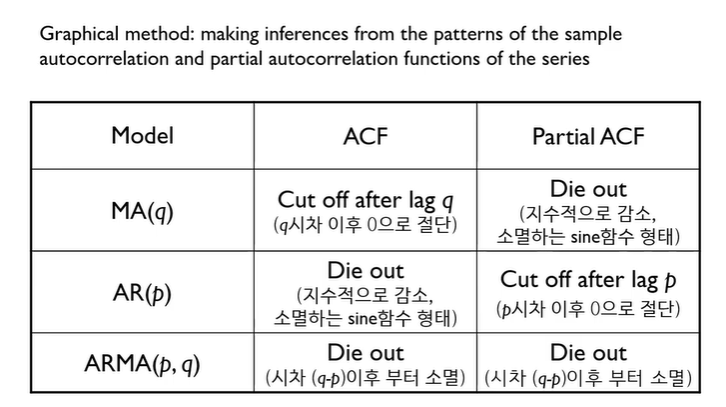

#### **궁금한 점 🤔**
MAPE 값은 별 차이가 없어도 그래프에서는 큰 차이를 보일 수가 있는 것일까? 그렇다면 왜???
<br>이부분은 아무래도 더 알아봐야 할 것 같다. (답답)

**참고한 레퍼런스**
<br>[python] ARIMA 데이터 생성 및 모형 적합 절차 https://hwao-story.tistory.com/13
<br>ARIMA, Python으로 하는 시계열분석 (feat. 비트코인 가격예측) https://byeongkijeong.github.io/ARIMA-with-Python/
<br>시계열 정상성 (Stationarity), 들어봤니? – 알아보자 시계열 분석 Episode 2 https://modulabs.co.kr/blog/time-series-stationarity/
<br>ARIMA 모델 개요 - Part 2 https://www.youtube.com/watch?v=P_3808Xv76Q&t=791s
<br>시계열분석 - ARIMA 모델 https://velog.io/@sjina0722/%EC%8B%9C%EA%B3%84%EC%97%B4%EB%B6%84%EC%84%9D-ARIMA-%EB%AA%A8%EB%8D%B8